In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import scipy.io as sci

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

from sklearn.model_selection import train_test_split
from functools import partial

### Files

In [22]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/'
else:
    path = './'

In [23]:
Y_file = sci.loadmat(path + 'Urban_R162.mat')
Y = Y_file['Y'].astype(float)

gt_file = sci.loadmat(path + 'end6_groundTruth.mat')
E = gt_file['M']

A_true = gt_file['A']

r_channels = 6
p = 162
nCol, nRow = 307, 307
n, m = 308, 308

Y.shape, E.shape, A_true.shape

((162, 94249), (162, 6), (6, 94249))

In [24]:
Y_b = np.zeros((p,n,m))
Y_b[:,:-1, :-1] = Y.reshape((p,nCol,nRow))
Y_b[:,-1, :], Y_b[:,:, -1] = Y_b[:,0,:], Y_b[:,:,0]
Y_b.shape

(162, 308, 308)

In [25]:
A_gt = np.zeros((r_channels, n, m))
A_gt[:,:-1, :-1] = A_true.reshape((r_channels,nCol,nRow))
A_gt[:,-1, :], A_gt[:,:, -1] = A_gt[:,0, :], A_gt[:,:, 0]
A_gt.shape

(6, 308, 308)

### Tensors

In [26]:
A_gt_tensor = torch.tensor(A_gt, dtype=torch.float32).reshape([r_channels,n,m])
E_tensor = torch.tensor(E, dtype=torch.float32)
Y_tensor = torch.tensor(Y_b, dtype=torch.float32).reshape([p,n*m])
A_gt_tensor.shape, E_tensor.shape, Y_tensor.shape

(torch.Size([6, 308, 308]), torch.Size([162, 6]), torch.Size([162, 94864]))

In [27]:
criterion = nn.MSELoss()
loss = criterion(torch.mm(E_tensor, A_gt_tensor.view(r_channels, n*m)), Y_tensor/1000)
loss

tensor(0.0054)

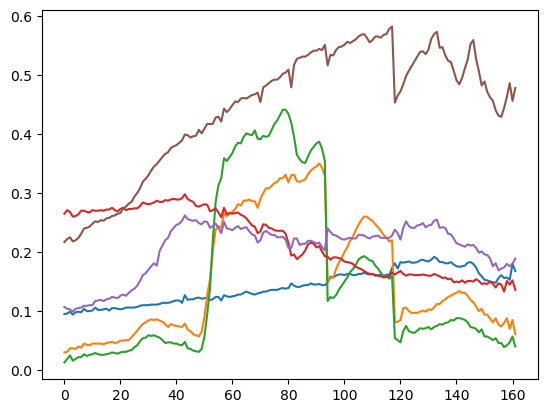

In [28]:
plt.plot(E_tensor)

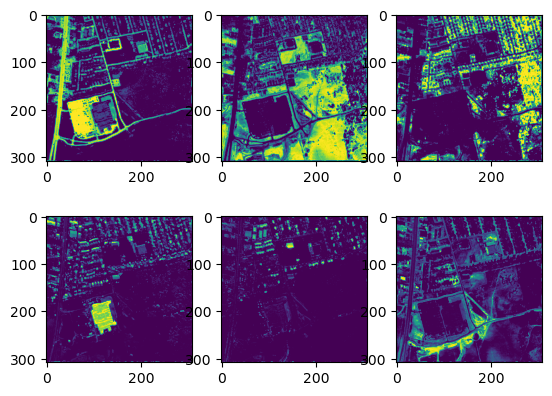

In [29]:
for i in range(r_channels): 
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(A_gt_tensor[i,:,:])

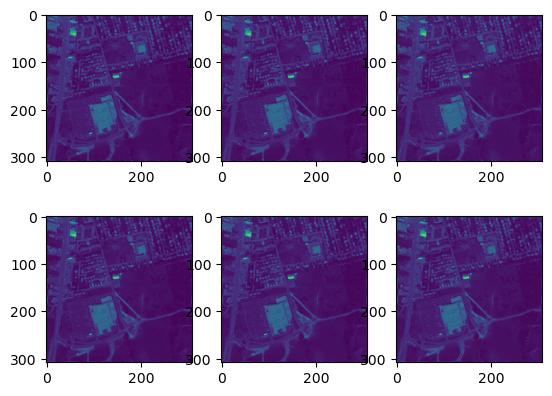

In [30]:
# Y
for i in range(r_channels): 
    ax = plt.subplot(2,3, i+1)
    ax.imshow((Y_tensor/1000).reshape(p,n,m)[i,:,:])

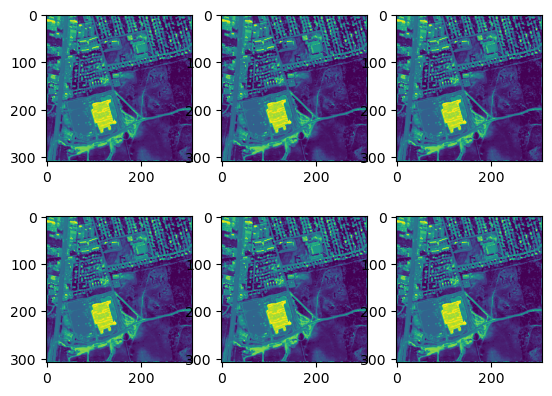

In [31]:
# E@A
for i in range(r_channels): 
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(torch.mm(E_tensor, A_gt_tensor.view(r_channels, n*m)).reshape(p,n,m)[i,:,:])

### Model

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


encoder_channels = [256,256]
decoder_channels = [256,256,r_channels]
skip_channels = 4

# Define the network architecture
class Undip_net_paper(nn.Module):
  def __init__(self):
    super(Undip_net_paper, self).__init__()
    
    self.encoder1 = nn.Sequential(nn.Conv2d(r_channels, encoder_channels[0], (3, 3), 
                                            stride=(2, 2), padding_mode='reflect', padding=1, dilation=1), # (308,308) to (154,154)
                                  nn.BatchNorm2d(encoder_channels[0]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), 
    )
    
    self.encoder2 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[1], (3, 3), 
                                            stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[1]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), # (154,154)
    )

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')


    self.skip = nn.Sequential(nn.Conv2d(r_channels, skip_channels, (1, 1), stride=(1, 1), 
                                        padding=0, dilation=1),
                              nn.BatchNorm2d(skip_channels),
                              nn.LeakyReLU(inplace=True, negative_slope=0.1),
    )
    
    
    
    self.decoder1 = nn.Sequential(nn.BatchNorm2d(encoder_channels[1]+skip_channels),
                                  nn.Conv2d(encoder_channels[1]+skip_channels, decoder_channels[0],
                                            (3, 3), stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[0]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1)
    )


   
    self.decoder2 = nn.Sequential(nn.Conv2d(decoder_channels[0], decoder_channels[1], (3, 3), 
                                            stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[1]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), # (77,77)
    )

    self.decoder3 = nn.Sequential(nn.Conv2d(decoder_channels[1], decoder_channels[2], (3, 3), 
                                            stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.Softmax(dim=1)
    )


  def forward(self, input):
    
        
    current_feature = self.encoder1(input)
    current_feature = self.encoder2(current_feature)
    current_feature = self.upsample(current_feature)
    
    current_skip_output = self.skip(input)

    current_feature = torch.cat((current_feature,current_skip_output), dim=1)
    
    
    current_feature = self.decoder1(current_feature)
    current_feature = self.decoder2(current_feature)
    output = self.decoder3(current_feature)
    
      
    return output



def train(model, input, E_tensor, Y_tensor, epochs=2000, lr=0.01):
  
  
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



  model = model.to(device)
  input = input.to(device)
  criterion = criterion.to(device)
  E_tensor = E_tensor.to(device)
  Y_tensor = Y_tensor.to(device)


  losses = []
  outputs = torch.zeros([epochs, 1, r_channels, n, m])
  model.eval() if optimizer is None else model.train()
  for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    
    optimizer.zero_grad()
    
    output = model(input)

    #loss = criterion(output.reshape(-1,r_channels)@end_member_estimation, gt_fractional_abundance)
    loss = criterion(torch.mm(E_tensor, output.view(r_channels, n*m)), Y_tensor)
    #loss = criterion(output, gt_fractional_abundance)

    print('Epoch {}: '.format(epoch), loss.item())
    losses.append(loss.item())
    outputs[epoch-1] = output.detach()
    
    loss.backward()
    optimizer.step()

  return outputs, losses



In [33]:
A = torch.normal(0,1,size=(1,r_channels,n,m), dtype=torch.float32)

In [34]:
Undip_model = Undip_net_paper()
# the training command
outputs, losses = train(Undip_model,A, E_tensor, Y_tensor/Y_tensor.max(), lr=0.001, epochs=100)

Epoch 1:  0.011576014570891857
Epoch 2:  0.008944897912442684
Epoch 3:  0.008794600144028664
Epoch 4:  0.008417004719376564
Epoch 5:  0.008136081509292126
Epoch 6:  0.007461330387741327
Epoch 7:  0.007001793943345547
Epoch 8:  0.006732838228344917
Epoch 9:  0.006257107947021723
Epoch 10:  0.006082787644118071
Epoch 11:  0.00559691246598959
Epoch 12:  0.005402037873864174
Epoch 13:  0.005208928603678942
Epoch 14:  0.00496576726436615
Epoch 15:  0.004847824573516846
Epoch 16:  0.004735866095870733
Epoch 17:  0.004492069128900766
Epoch 18:  0.0043647149577736855
Epoch 19:  0.004316647537052631
Epoch 20:  0.004161689896136522
Epoch 21:  0.004080039914697409
Epoch 22:  0.0039855982176959515
Epoch 23:  0.0038821622729301453
Epoch 24:  0.0038259411230683327
Epoch 25:  0.0037377714179456234
Epoch 26:  0.003669087076559663
Epoch 27:  0.0036167786456644535
Epoch 28:  0.003540506586432457
Epoch 29:  0.0034945665393024683
Epoch 30:  0.003425148781388998
Epoch 31:  0.0033803449478000402
Epoch 32:  

In [35]:
A_ = outputs[-1]

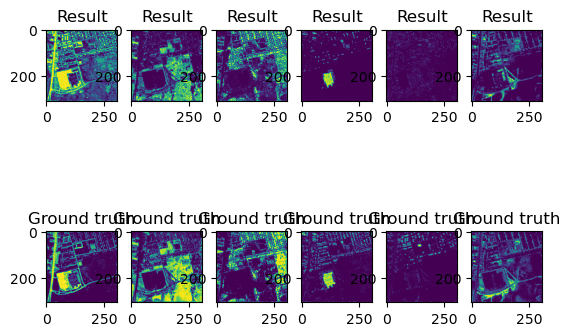

In [36]:
for i in range(r_channels): 
    ax = plt.subplot(2, r_channels, i+1)
    im = A_
    im = im[0, i,:,:]
    ax.imshow(im)
    plt.title('Result')

for i in range(r_channels): 
      ax = plt.subplot(2, r_channels, i+1+r_channels)
      im = A_gt_tensor.view([1,r_channels,n,m])
      im = im[0,i,:,:]
      ax.imshow(im)
      plt.title('Ground truth')

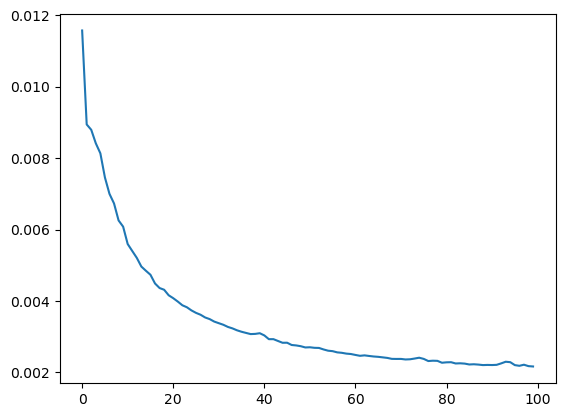

In [37]:
plt.plot(losses)

### Ecart avec groud truth

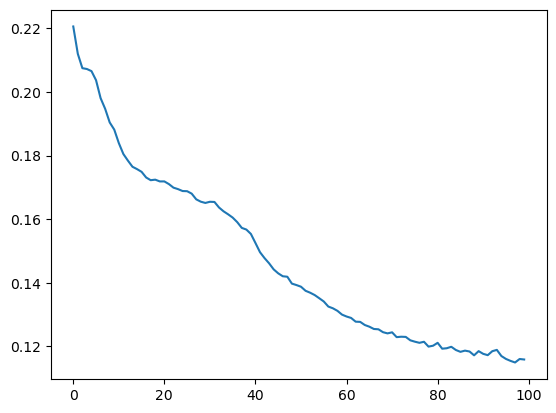

In [39]:
ecarts = []
for k in range(100):
  ecarts.append(nn.L1Loss()(outputs[k], A_gt_tensor.view([1,r_channels,n,m])))

plt.plot(ecarts)